In [65]:
import networkx as nx
import custom_funcs as cf
import pandas as pd
import matplotlib.pyplot as plt
import dendropy

from Levenshtein import distance
from collections import defaultdict, Counter
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO, AlignIO
from Bio.Align import MultipleSeqAlignment
from itertools import product

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
G = nx.read_gpickle('20150902_all_ird Final Graph.pkl')
G = cf.clean_host_species_names(G)
G = cf.impute_reassortant_status(G)
G = cf.impute_weights(G)

In [3]:
G.nodes(data=True)[1286]

('A/Tennessee/F2018A/2011',
 {'collection_date': Timestamp('2011-01-24 00:00:00'),
  'country': 'USA',
  'host_species': 'Human',
  'reassortant': False,
  'state': 'Tennessee',
  'subtype': 'H3N2'})

In [4]:
# Get all of the host species with TOL and BOLD links
hosts_with_coi = pd.read_csv('host_species.csv', index_col=0)
hosts_with_coi

,host_species,TOL_species_name,TOL_url,sequence,BOLD_url,notes
0,Sparrow,NaN,NaN,NaN,NaN,ambiguous term
1,American Green-Winged Teal,Anas carolinensis,http://tolweb.org/Anas_carolinensis/89249,TCTATACCTTATCTTCGGGGCATGAGCCGGAATAATTGGCACAGCA...,http://boldsystems.org/index.php/Public_Record...,NaN
2,Turkey,Meleagris gallopavo,http://tolweb.org/Meleagris/57202,GTGACTTTCATCAACCGATGATTATTTTCAACCAACCATAAAGATA...,http://boldsystems.org/index.php/Public_Record...,NaN
3,Semipalmated Sandpiper,Calidris pusilla,http://tolweb.org/Calidris_pusilla/90811,GTGACTTTTATCAACCGATGACTATTCTCAACCAACCACAAAGATA...,http://boldsystems.org/index.php/Public_Record...,NaN
4,Murre,NaN,NaN,NaN,NaN,not available on TOL
5,Heron,NaN,NaN,NaN,NaN,more than one record on TOL
6,Wood Duck,Aix sponsa,http://tolweb.org/Aix/89196,CTTGTACCTTATCTTCGGGGCATGAGCCGGAATAATTGGCACAGCA...,http://boldsystems.org/index.php/Public_Record...,NaN
7,Myna,NaN,NaN,NaN,NaN,not available on TOL
8,Ostrich,Struthio camelus,http://tolweb.org/Struthio_camelus/26289,GTGACCTTCATTACTCGATGACTTTTTTCAACAAATCACAAAGACA...,http://boldsystems.org/index.php/Public_Record...,NaN
9,Ruddy Turnstone,Arenaria interpres,http://tolweb.org/Arenaria_interpres/90804,GTGACTTTTATCAACCGATGACTATTCTCAACCAACCACAAAGATA...,http://boldsystems.org/index.php/Public_Record...,NaN


In [5]:
# Compile COI sequences into a FASTA file to do multiple sequence alignment.

coi_sequences = []
for r, d in hosts_with_coi.iterrows():
    if not pd.isnull(d['sequence']):
        seq = Seq(d['sequence'])
        seqrecord = SeqRecord(seq, id='{0}.{1}'.format(d['host_species'].replace(' ', '_'), d['TOL_species_name'].replace(' ', '_')))
        coi_sequences.append(seqrecord)
SeqIO.write(coi_sequences, 'host_coi_unaligned.fasta', 'fasta')

74

In [6]:
# After aligning using clustal omega (default parameters), load back the alignment.
coi_aligned = AlignIO.read('host_coi_aligned.fasta', 'fasta')
coi_aligned

<<class 'Bio.Align.MultipleSeqAlignment'> instance (74 records of length 1638, SingleLetterAlphabet()) at 7f6e604a9710>

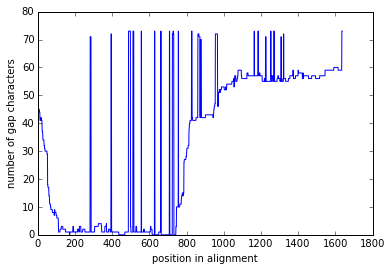

In [7]:
# To identify where to trim the alignment, look at the number of gaps.

num_gaps = dict()
for i in range(coi_aligned.get_alignment_length()):
    num_gaps[i] = Counter(coi_aligned[:,i])['-']
plt.plot(list(num_gaps.keys()), list(num_gaps.values()))
plt.xlabel('position in alignment')
plt.ylabel('number of gap characters')

In [8]:
# Given this distribution of gaps, we will use a cut-off of 3 gaps to trim the alignment.
# i.e. if there are more than 3 gaps at that position, we trim that position out.

coi_df = pd.DataFrame([s for s in coi_aligned])
index = [s.id for s in coi_aligned]

for i in range(coi_aligned.get_alignment_length()):
    num_gaps = Counter(coi_aligned[:,i])['-']
    if num_gaps > 3:
        coi_df = coi_df.drop(i, axis=1)
coi_df.index = index
coi_df

,111,112,113,114,115,116,117,118,119,120,...,736,737,738,739,740,741,742,743,744,745
Human.Homo_sapiens,T,T,G,G,T,T,C,G,G,G,...,T,C,G,T,G,A,T,G,T,C
Kelp_Gull.Larus_dominicanus,A,T,G,G,C,C,C,C,A,A,...,A,A,C,A,C,T,A,A,C,C
Baikal_Teal.Anas_formosa,A,T,G,G,C,C,C,C,A,A,...,A,A,C,C,C,T,A,A,C,C
Redhead.Aythya_americana,-,C,A,A,C,C,T,C,A,-,...,C,G,A,G,G,C,A,T,T,C
Ferret.Mustela_putorius,A,T,C,C,G,T,G,C,T,G,...,A,C,A,C,T,T,A,T,T,T
Sloth_Bear.Melursus_ursinus,A,T,T,C,G,T,G,C,C,G,...,A,C,A,C,T,T,G,T,T,C
Panda.Ailuropoda_melanoleuca,A,T,C,C,G,T,G,C,T,G,...,A,C,A,T,C,T,A,T,T,T
Camel.Camelus_dromedarius,A,T,T,C,G,T,G,C,T,G,...,A,C,A,C,C,T,A,T,T,T
Horse.Equus_ferus_caballus,A,T,C,C,G,T,G,C,T,G,...,A,C,A,C,C,T,A,T,T,C
Domestic_Cat.Felis_catus,-,T,C,C,G,G,G,C,C,G,...,A,C,A,C,T,T,A,T,T,C


In [9]:
# Now, I have to concatenate the sequences back into a single string.
trimmed_coi = []
for host_name, letters in coi_df.iterrows():
    sequence = ''
    for letter in coi_df.ix[host_name]:
        sequence += letter
    seq = Seq(sequence)
    seqrecord = SeqRecord(seq, description='', id=host_name, name='')
    trimmed_coi.append(seqrecord)
SeqIO.write(trimmed_coi, 'host_coi_trimmed.fasta', 'fasta')

74

In [10]:
trimmed_coi

[SeqRecord(seq=Seq('TTGGTTCGGGGTATGG-----------------------GGTTAGCAGCGGTGT...GTC', Alphabet()), id='Human.Homo_sapiens', name='', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGCCCCAAATCTACGAAAATCTCACCCCCTCCTCAAAATAGTTAACAACTCA...ACC', Alphabet()), id='Kelp_Gull.Larus_dominicanus', name='', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGCCCCAAATATCCGCAAATCCCACCCCCTACTAAAAATAATCAACAACTCC...ACC', Alphabet()), id='Baikal_Teal.Anas_formosa', name='', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('-CAACCTCA---------------GGACTAATCATATGATTCCACTATAACTCA...TTC', Alphabet()), id='Redhead.Aythya_americana', name='', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('ATCCGTGCTGAACTAGGTCAACCTGGCACTCTGCTAGGAGACGACCAGATTTAT...TTT', Alphabet()), id='Ferret.Mustela_putorius', name='', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('ATTCGTGCCGAACTAGGTCAACCCGGGGCTCTGTTGGGGGATGATCAGATCTAC...TTC', Alphabet()), id='Sloth_Bear.Melursus_ursinus', name='', description='', dbxrefs=[]),
 SeqRecord(

In [11]:
# Filter out COI sequences such that only those without gaps are left. This is so that we can do a phylogenetic tree.
no_gaps = []
for s in trimmed_coi:
    if '-' not in s.seq:
        no_gaps.append(s)
no_gaps

[SeqRecord(seq=Seq('ATCCGTGCTGAACTAGGTCAACCTGGCACTCTGCTAGGAGACGACCAGATTTAT...TTT', Alphabet()), id='Ferret.Mustela_putorius', name='', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('ATTCGTGCCGAACTAGGTCAACCCGGGGCTCTGTTGGGGGATGATCAGATCTAC...TTC', Alphabet()), id='Sloth_Bear.Melursus_ursinus', name='', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('ATCCGTGCTGAATTAGGTCAGCCTGGAGCTCTGTTAGGAGATGACCAAATTTAC...TTT', Alphabet()), id='Panda.Ailuropoda_melanoleuca', name='', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('ATTCGTGCTGAATTGGGGCAGCCTGGGACATTGCTTGGAGATGACCAAATCTAT...TTT', Alphabet()), id='Camel.Camelus_dromedarius', name='', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('ATCCGTGCTGAATTAGGCCAACCTGGGACCCTACTAGGAGATGATCAGATCTAC...TTC', Alphabet()), id='Horse.Equus_ferus_caballus', name='', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('ATTCGCGCTGAACTAGGTCAGCCCGGAACCCTACTTGGCGATGATCAAATCTAC...TTC', Alphabet()), id='Swine.Sus_scrofa', name='', description='', dbxrefs=[]),
 SeqRecor

In [12]:
SeqIO.write(no_gaps, 'host_coi_nogaps.fasta', 'fasta')
SeqIO.write(no_gaps, 'host_coi_nogaps.phylip', 'phylip')

65

In [13]:
# Get the distribution of hamming distances.
from itertools import combinations
from Levenshtein import distance
distances = []
for s1, s2 in combinations(no_gaps, 2):
    s1 = str(s1.seq)
    s2 = str(s2.seq)
    distances.append(distance(s1,s2))

(array([  23.,   14.,   38.,  232.,  225.,  193.,  692.,  334.,  239.,   90.]),
 array([   0. ,   14.9,   29.8,   44.7,   59.6,   74.5,   89.4,  104.3,
         119.2,  134.1,  149. ]),
 <a list of 10 Patch objects>)

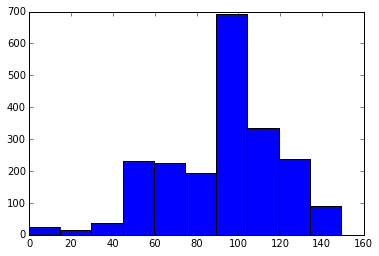

In [14]:
plt.hist(distances)

# Construct Phylogenetic Tree

In [15]:
!! raxmlHPC -p 100 -# 3 -m GTRGAMMA -s host_coi_nogaps.fasta -n host_coi_nogaps.tree -T 2

['Option -T does not have any effect with the sequential or parallel MPI version.',
 'It is used to specify the number of threads for the Pthreads-based parallelization',
 '',
 "RAxML can't, parse the alignment file as phylip file ",
 'it will now try to parse it as FASTA file',
 '',
 'RAxML output files with the run ID <host_coi_nogaps.tree> already exist ',
 'in directory /home/ericmjl/influenza-global-reassortment/ ...... exiting']

In [16]:
!! ls *.tree

['RAxML_bestTree.host_coi_nogaps.tree', 'RAxML_info.host_coi_nogaps.tree']

# Compute pairwise patristic distances in the phylogenetic tree

In [26]:
from dendropy import Tree
from dendropy.calculate.treemeasure import PatristicDistanceMatrix
coi_tree = Tree.get(file=open('RAxML_bestTree.host_coi_nogaps.tree', 'r'),
                    schema='newick')


coi_pds = PatristicDistanceMatrix(coi_tree)
coi_pds.sum_of_distances()

1015.7242854563826

In [31]:
taxon1 = coi_tree.leaf_nodes()[0].taxon
taxon2 = coi_tree.leaf_nodes()[1].taxon

In [50]:
taxon2 = coi_tree.leaf_nodes()[1].taxon.__str__()
taxon2.replace("'","")

'Horse.Equus ferus caballus'

In [34]:
coi_pds.__call__(taxon1, taxon2)

0.7119165546950544

In [67]:
patristic_distances = nx.Graph()
pds = []
for taxon1, taxon2 in product(coi_tree.leaf_nodes(), coi_tree.leaf_nodes()):
    taxon1 = taxon1.taxon
    taxon2 = taxon2.taxon
    
    pd = coi_pds.__call__(taxon1, taxon2)
    t1 = taxon1.__str__().replace("'","").split('.')[0]
    t2 = taxon2.__str__().replace("'","").split('.')[0]
    patristic_distances.add_edge(t1, t2, pd=pd)
    pds.append(pd)

(array([ 403.,  782.,  364.,  896.,  990.,  106.,   88.,  162.,  354.,   80.]),
 array([ 0.        ,  0.12690987,  0.25381974,  0.38072961,  0.50763948,
         0.63454935,  0.76145921,  0.88836908,  1.01527895,  1.14218882,
         1.26909869]),
 <a list of 10 Patch objects>)

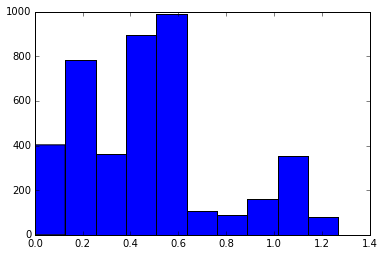

In [68]:
plt.hist(pds)

In [69]:
max(pds)

1.2690986907853712

In [70]:
min(pds)

0.0

In [71]:
nx.write_gpickle(patristic_distances, 'supp_data/patristic_distances.pkl')

In [73]:
patristic_distances.edge['Mallard']

{'American Black Duck': {'pd': 0.00978530479098707},
 'American Green-Winged Teal': {'pd': 0.0760159068606335},
 'American Wigeon': {'pd': 0.05329789418179376},
 'Bar-Headed Goose': {'pd': 0.16440706032963423},
 'Barnacle Goose': {'pd': 0.1525078793951098},
 'Black Scoter': {'pd': 0.1313820887207964},
 'Brown-Headed Gull': {'pd': 0.5359870461849322},
 'Bufflehead': {'pd': 0.13844900323749146},
 'Camel': {'pd': 1.139610961267169},
 'Canada Goose': {'pd': 0.1487864476189279},
 'Canvasback': {'pd': 0.12777814104578533},
 'Chinese Francolin': {'pd': 0.41679378743034057},
 'Common Eider': {'pd': 0.12320986574712678},
 'Common Goldeneye': {'pd': 0.1250179531566235},
 'Common Murre': {'pd': 0.5037977010375587},
 'Dunlin': {'pd': 0.5541468716317777},
 'Ferret': {'pd': 1.0052196033816883},
 'Gadwall': {'pd': 0.06077763709949219},
 'Garganey': {'pd': 0.09094589474066593},
 'Glaucous Gull': {'pd': 0.5522423313203503},
 'Great Crested Grebe': {'pd': 0.4322418927584293},
 'Greater Scaup': {'pd': 0.